In [147]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from vgg16 import VGG16
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam

In [2]:
token = 'Flickr8k_text/Flickr8k.token.txt'

In [3]:
captions = open(token, 'r').read().strip().split('\n')

## Creating a dictionary containing all the captions of the images

In [4]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [5]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [6]:
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [7]:
img = glob.glob(images+'*.jpg')

In [8]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'

In [9]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [10]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [11]:
train_img = split_data(train_images)
len(train_img)

6000

In [12]:
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [13]:
val_img = split_data(val_images)
len(val_img)

1000

In [14]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [15]:
test_img = split_data(test_images)
len(test_img)

1000

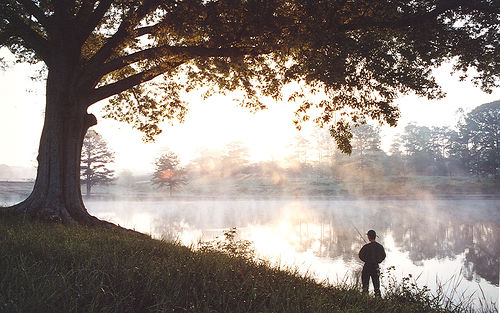

In [16]:
Image.open(train_img[0])

In [17]:
def subtract_mean(img):
    mean_sub = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    return (img - mean_sub)[:,:,:,::-1]

In [18]:
def preprocess(image):
    img = Image.open(image)
    img = img.resize((224,224), Image.NEAREST)
    img = np.array(img)
    img = np.expand_dims(img, 0)
    img = subtract_mean(img)
    return img

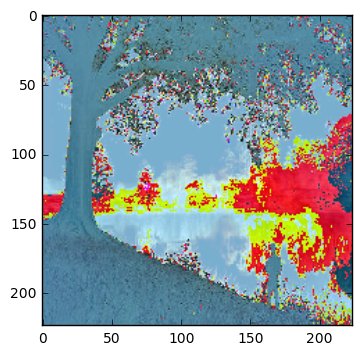

In [19]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [20]:
model = VGG16()
model.load_weights('vgg16_tf.h5')

In [21]:
model.pop()
model.pop()
model.trainable = False
for i in model.layers:
    i.trainable = False

In [22]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_1 (ZeroPadding2D)  (None, 226, 226, 3)   0           zeropadding2d_input_1[0][0]      
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 224, 224, 64)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 226, 226, 64)  0           conv1_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 224, 224, 64)  36928       zeropadding2d_2[0][0]            
___________________________________________________________________________________________

In [23]:
tryi = model.predict(preprocess(train_img[0]))

In [24]:
tryi.shape

(1, 4096)

In [20]:
def encode(image):
    image = preprocess(image)
    temp_enc = model.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [34]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)


100%|██████████| 6000/6000 [1:57:49<00:00,  1.36s/it]


In [36]:
with open("encoded_images.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [41]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(4096,)

In [20]:
encoding_train = pickle.load(open('encoded_images.p', 'rb'))

In [21]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [22]:
len(train_d)

6000

In [23]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [62]:
with open("training_images_captions.p", "wb") as pickle_d:
    pickle.dump(train_d, pickle_d)

In [24]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [25]:
len(val_d)

1000

In [65]:
with open("validation_images_captions.p", "wb") as pickle_d:
    pickle.dump(val_d, pickle_d) 

In [26]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [27]:
len(test_d)

1000

In [68]:
with open("test_images_captions.p", "wb") as pickle_d:
    pickle.dump(test_d, pickle_d) 

In [28]:
caps = []
for key, val in d.items():
    for i in val:
        caps.append(i)

In [29]:
words = [i.split() for i in caps]

In [30]:
unique = []
for i in words:
    unique.extend(i)

In [31]:
unique.extend("<start>".split())
unique.extend("<end>".split())

In [32]:
unique = list(set(unique))

In [33]:
len(unique)

9632

In [34]:
word2idx = {val:index for index, val in enumerate(unique)}

In [35]:
word2idx['<end>']

4710

In [36]:
idx2word = {index:val for index, val in enumerate(unique)}

In [38]:
idx2word[4710]

'<end>'

In [39]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

38

In [40]:
len(unique), max_len

(9632, 38)

In [89]:
vocab_size = len(unique)

In [135]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [136]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [168]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [169]:
len(df)

30000

In [170]:
c = [i for i in df['captions']]

In [171]:
imgs = [i for i in df['image_id']]

In [172]:
a = c[0]

In [173]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 7031
A => 4777
basketball => 4805
player => 1281
wearing => 2176
an => 4429
orange => 5221
uniform => 494
looks => 7608
backwards => 1053
. => 7051
<end> => 4710


In [192]:
samples_per_epoch = 0
for ca in caps:
    ca = "<start> " + ca + " <end>"
    samples_per_epoch += len(ca.split())-1

In [194]:
samples_per_epoch

517166

## Generator

In [195]:
def data_generator(batch_size=32):
    partial_caps = []
    next_words = []
    images = []
    count = 0
    for i, text in enumerate(c):
        current_image = encoding_train[imgs[i]]
        for j in range(len(text.split())-1):
            count+=1
            partial = [word2idx[t] for t in text.split()[:j+1]]
            partial_caps.append(partial)
            # Initializing with zeros to create a one-hot encoding matrix
            # This is what we have to predict
            # Hence initializing it with vocab_size length
            next = np.zeros(vocab_size)
            # Setting the next word to 1
            next[word2idx[text.split()[j+1]]] = 1
            next_words.append(next)
            images.append(current_image)
            
            if count >= batch_size:
                images = np.array(images)
                next_words = np.array(next_words)
                partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                yield [[images, partial_caps], next_words]
                partial_caps = []
                images = []
                next_words = []
                count = 0

In [196]:
for i, val in enumerate(data_generator()):
    if i==0:
        print (val)

[[array([[ 0.        ,  1.15606487,  0.        , ...,  0.        ,
         0.        ,  3.6591897 ],
       [ 0.        ,  1.15606487,  0.        , ...,  0.        ,
         0.        ,  3.6591897 ],
       [ 0.        ,  1.15606487,  0.        , ...,  0.        ,
         0.        ,  3.6591897 ],
       ..., 
       [ 0.        ,  1.15606487,  0.        , ...,  0.        ,
         0.        ,  3.6591897 ],
       [ 0.        ,  1.15606487,  0.        , ...,  0.        ,
         0.        ,  3.6591897 ],
       [ 0.        ,  1.15606487,  0.        , ...,  0.        ,
         0.        ,  3.6591897 ]], dtype=float32), array([[7031,    0,    0, ...,    0,    0,    0],
       [7031, 4777,    0, ...,    0,    0,    0],
       [7031, 4777, 4805, ...,    0,    0,    0],
       ..., 
       [7031, 1229, 4805, ...,    0,    0,    0],
       [7031,    0,    0, ...,    0,    0,    0],
       [7031, 1229,    0, ...,    0,    0,    0]], dtype=int32)], array([[ 0.,  0.,  0., ...,  0.,  0.,  

## Let's create the model

In [203]:
embedding_size = 256

In [204]:
image_model = Sequential([
        Dense(embedding_size, input_dim=4096, activation='relu'),
        RepeatVector(max_len)
    ])

In [205]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(embedding_size, activation='relu'))
    ])

In [206]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat'),
        LSTM(256, return_sequences=False),
        Dense(vocab_size, activation='softmax')
    ])

In [207]:
final_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [208]:
final_model.fit_generator(data_generator(), samples_per_epoch=samples_per_epoch, nb_epoch=10)

Epoch 1/10
  2208/517166 [..............................] - ETA: 13165s - loss: 6.7159 - acc: 0.0670

KeyboardInterrupt: 